# Multivariate Fuzzy C-medoids method: Implementation

## Equations

### $J= \sum_{i=1}^{c} \sum_{k=1}^{n} \sum_{j=1}^{p} \left(u_{ijk} \right)^{m} d_{ijk}$ - Objective function to minimize.

### $d_{ijk} = \left(x_{jk} - y_{ij} \right)^{2}$ - euclidian distance squared.

### $q = \argmin_{1 \le i \le c} \sum_{j=1}^p \sum_{k=1}^n (u_{ijk})^m \cdot d_{ijk}$ - prototype coordinate of a given cluster in feature j.

### $ u_{ijk} =  \left[\sum_{h=1}^{c}\sum_{l=1}^{p} \left(\frac{d_{ijk}}{d_{hlk}}\right)^{(1/(m-1))}  \right]^{-1} $ - membership degree of pattern k in cluster $C_{i}$ on the feature j.

### $\delta_{ik} = \sum_{j=1}^{p} u_{ijk}$ - represents an aggregation measure for all the p features.

## Constraints:

### - $u_{ijk} \in [0, 1]$ for all i, j and k;
### - $0 < \sum_{j=1}^{p} \sum_{k=1}^{n} u_{ijk} < n$ for all i and
### - $\sum_{i=1}^{c}\sum_{j=1}^{p}u_{ijk} = 1$ for all k.

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Tratamento dos dados

In [11]:
df = pd.read_csv('/workspaces/Fuzzy_Clustering/datasets/wine.csv')
df = df.rename(columns={'Wine': 'Class'})
df["Class"].replace({1: 0, 2: 1, 3: 2}, inplace=True)
labels = df["Class"].values
df.drop("Class", axis=1, inplace=True)
#df = df[["Alcohol", "Malic.acid", "Proline", "Mg", "Phenols", "OD", "Nonflavanoid.phenols"]]
dados = df.to_numpy()
#scaler = StandardScaler()
scaler = MinMaxScaler()
dados = scaler.fit_transform(dados)

/tmp/ipykernel_3995/3742774291.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Class"].replace({1: 0, 2: 1, 3: 2}, inplace=True)


In [12]:
df.head()

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Método de agrupamento

In [13]:
class MFCMedoids:
    def __init__(self, c, X, m):
        self.c = c
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.m = m
        self.epsilon = 1e-10  # To prevent division by zero

    def initialize_u(self):
        return np.random.dirichlet(alpha=np.ones(self.c * self.p),
                                   size=self.n).reshape(self.n, self.c, self.p)

    def find_medoids(self, X, U):
        medoids = np.zeros((self.c, self.p))
        U_m = U ** self.m  # (n, c, p)

        # Para cada possível q (0 <= q < n), criamos um tensor de distâncias quadradas para todos os outros k e p
        # (n, n, p) -> distances_squared[k, q, j] = (X[k, j] - X[q, j]) ** 2
        distances_squared = np.abs(X[:, np.newaxis, :] - X[np.newaxis, :, :])  # city block

        for i in range(self.c):
            # Para o cluster i, obtemos U_m[:, i, :] -> shape (n, p)
            # Queremos calcular o custo de cada q ser o medoide: somatório sobre j e k de u_m[k, i, j] * d(k, q, j)
            
            # Expand u_m para fazer broadcast: (n, 1, p) para multiplicar com (n, n, p)
            u_m_expanded = U_m[:, i, :][:, np.newaxis, :]  # shape (n, 1, p)

            # Custo total para cada q: soma sobre k e j
            cost_per_q = np.sum(u_m_expanded * distances_squared, axis=(0, 2))  # shape (n,)

            best_q = np.argmin(cost_per_q)
            medoids[i] = X[best_q]

        return medoids


    def get_distances(self, X, medoids):
        return np.abs(X[:, np.newaxis, :] - medoids[np.newaxis, :, :]) # city block

    def update_u(self, D):
        D = np.maximum(D, self.epsilon)  # Avoid division by zero
        ratio = (D[:, np.newaxis, np.newaxis, :, :] / D[:, :, :, np.newaxis, np.newaxis]) ** (1 / (self.m - 1))
        return 1 / np.sum(ratio, axis=(3, 4))

    def get_objective_function(self, U, D):
        return np.sum((U ** self.m) * D)

# Clustering

In [14]:
def mfcm_run(dados, num_clusters, m=2, max_iter=1000, epsilon=1e-5):
    mfcm = MFCMedoids(c=num_clusters, X=dados, m=m)  # Create the MFCMedoids object

    U = mfcm.initialize_u()  # Initialize the membership matrix

    for _ in range(max_iter):
        medoids = mfcm.find_medoids(dados, U)
        D = mfcm.get_distances(dados, medoids)
        new_U = mfcm.update_u(D)
        
        # Check for convergence
        if np.linalg.norm(U - new_U) < epsilon:
            break
        
        U = new_U

    Delta = np.sum(U, axis=2)  # Summing over the second axis (variables j)

    return medoids, U, Delta

## Simulação de Monte Carlo

In [15]:
def monte_carlo_simulation(dados, labels, num_clusters, num_trials):
    results = []
    for _ in range(num_trials):
        print(_)
        medoids, U, Delta = mfcm_run(dados, num_clusters)
        predicted_labels = np.argmax(Delta, axis=1)
        ari = adjusted_rand_score(labels, predicted_labels)
        if ari > 0.1:
            results.append(ari)
    mean_rand_index = np.mean(results)
    std_rand_index = np.std(results)
    return mean_rand_index, std_rand_index, medoids

In [17]:
num_clusters = 3
num_trials = 1
mean_rand_index, std_rand_index, medoids = monte_carlo_simulation(dados, labels, num_clusters, num_trials)

print(f"Mean ARI: {mean_rand_index}")
print(f"Std ARI: {std_rand_index}")
print(f"Medoids: {medoids}")

0
Mean ARI: 0.4847385885049859
Std ARI: 0.0
Medoids: [[0.58947368 0.69960474 0.48128342 0.48453608 0.54347826 0.21034483
  0.07383966 0.56603774 0.29652997 0.76109215 0.08943089 0.10622711
  0.39728959]
 [0.44473684 0.21146245 0.44919786 0.42268041 0.17391304 0.42068966
  0.46202532 0.24528302 0.42902208 0.22354949 0.55284553 0.68498168
  0.31098431]
 [0.44473684 0.21146245 0.44919786 0.42268041 0.17391304 0.42068966
  0.46202532 0.24528302 0.42902208 0.22354949 0.55284553 0.68498168
  0.31098431]]


In [110]:
num_clusters = 3
num_trials = 100
mean_rand_index, std_rand_index = monte_carlo_simulation(dados, labels, num_clusters, num_trials)

print(f"Mean ARI: {mean_rand_index}")
print(f"Std ARI: {std_rand_index}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Mean ARI: 0.5817096237352422
Std ARI: 0.049908718998853865


In [8]:
def medoide_global_calc(dados, u_ijk, m=2):
    n_objetos, p_variaveis = dados.shape
    u_ijk_m = u_ijk ** m
    pesos_kj = np.sum(u_ijk_m, axis=0).T

    min_dissimilarity = np.inf
    medoid_index = -1

    for q in range(n_objetos):  # testa cada ponto como candidato a medoide
        candidato_q = dados[q, :]
        distancias_abs = np.abs(dados - candidato_q)  # cityblock componentwise
        dissimilaridade_total_q = np.sum(pesos_kj * distancias_abs)

        if dissimilaridade_total_q < min_dissimilarity:
            min_dissimilarity = dissimilaridade_total_q
            medoid_index = q

    return dados[medoid_index, :]


def indices(dados, prototipos, u_ijk, m=2):
    n, p = dados.shape
    c, _, _ = u_ijk.shape
    u_ijk_m = u_ijk ** m

    grupo_nomes = [f'Grupo_{i+1}' for i in range(c)]
    variavel_nomes = [f'Var_{j+1}' for j in range(p)]

    # medoide global
    z = medoide_global_calc(dados, u_ijk, m)

    # --- 1. Intra-grupo (J) ---
    dist_intra = np.abs(dados.T.reshape(1, p, n) - prototipos.reshape(c, p, 1))
    J_ijk = u_ijk_m * dist_intra
    J = np.sum(J_ijk)
    J_por_grupo = np.sum(J_ijk, axis=(1, 2))
    J_por_variavel = np.sum(J_ijk, axis=(0, 2))
    J_ij = np.sum(J_ijk, axis=2)

    # --- 2. Inter-grupo (B) ---
    dist_inter = np.abs(prototipos - z)
    B_ijk = u_ijk_m * dist_inter.reshape(c, p, 1)
    B = np.sum(B_ijk)
    B_por_variavel = np.sum(B_ijk, axis=(0, 2))
    B_por_grupo = np.sum(B_ijk, axis=(1, 2))
    B_ij = np.sum(B_ijk, axis=2)

    # --- 3. Total (T = B + J) ---
    T = B + J
    T_por_variavel = B_por_variavel + J_por_variavel
    T_por_grupo = B_por_grupo + J_por_grupo
    T_ij = B_ij + J_ij

    # --- 4. Índices ---
    R_global = B / T if T > 0 else 0

    COR_j = np.divide(B_por_variavel, T_por_variavel, out=np.zeros_like(B_por_variavel), where=T_por_variavel!=0)
    CTR_j = np.divide(B_por_variavel, B, out=np.zeros_like(B_por_variavel), where=B!=0)
    df_indices_variavel = pd.DataFrame({'COR(j)': COR_j, 'CTR(j)': CTR_j}, index=variavel_nomes)

    T_i_rel = np.divide(T_por_grupo, T, out=np.zeros_like(T_por_grupo), where=T!=0)
    J_i_rel = np.divide(J_por_grupo, J, out=np.zeros_like(J_por_grupo), where=J!=0)
    B_i_rel = np.divide(B_por_grupo, B, out=np.zeros_like(B_por_grupo), where=B!=0)
    df_indices_grupo = pd.DataFrame({'T(i)': T_i_rel, 'J(i)': J_i_rel, 'B(i)': B_i_rel}, index=grupo_nomes)

    COR_ij = np.divide(B_ij, T_por_variavel, out=np.zeros_like(B_ij), where=T_por_variavel!=0)
    df_cor_ij = pd.DataFrame(COR_ij.T, index=variavel_nomes, columns=grupo_nomes)

    CTR_ij = np.divide(B_ij, B_por_grupo.reshape(-1, 1), out=np.zeros_like(B_ij), where=B_por_grupo.reshape(-1, 1)!=0)
    df_ctr_ij = pd.DataFrame(CTR_ij.T, index=variavel_nomes, columns=grupo_nomes)

    CE_ij = np.divide(B_ij, B, out=np.zeros_like(B_ij), where=B!=0)
    df_ce_ij = pd.DataFrame(CE_ij.T, index=variavel_nomes, columns=grupo_nomes)

    return {
        'T_total_bruto': T,
        'B_total_bruto': B,
        'J_total_bruto': J,
        'dispersao_bruta_por_grupo': pd.DataFrame({'Ti': T_por_grupo, 'Bi': B_por_grupo, 'Ji': J_por_grupo}, index=grupo_nomes),
        'dispersao_bruta_por_variavel': pd.DataFrame({'Tj': T_por_variavel, 'Bj': B_por_variavel, 'Jj': J_por_variavel}, index=variavel_nomes),
        'T_ij_bruto': pd.DataFrame(T_ij.T, index=variavel_nomes, columns=grupo_nomes),
        'B_ij_bruto': pd.DataFrame(B_ij.T, index=variavel_nomes, columns=grupo_nomes),
        'J_ij_bruto': pd.DataFrame(J_ij.T, index=variavel_nomes, columns=grupo_nomes),
        'R_global': R_global,
        'indices_por_variavel': df_indices_variavel,
        'indices_por_grupo': df_indices_grupo,
        'COR(i,j)': df_cor_ij,
        'CTR(i,j)': df_ctr_ij,
        'CE(i,j)': df_ce_ij
    }



medoides_resultado, U_resultado, _ = mfcm_run(dados, num_clusters=3, m=2)
u_ijk_para_analise = U_resultado.transpose(1, 2, 0)

indices = indices(
    dados=dados, 
    prototipos=medoides_resultado, 
    u_ijk=u_ijk_para_analise, 
    m=2
)

print("--- 1. Medidas de Dispersão Bruta Totais ---")
print(f"  T (Dispersão Total): {indices['T_total_bruto']:.4f}")
print(f"  B (Dispersão Inter-grupo): {indices['B_total_bruto']:.4f}")
print(f"  J (Dispersão Intra-grupo): {indices['J_total_bruto']:.4f}\n")

print("--- 2. Medidas de Dispersão Bruta por Grupo (Ti, Bi, Ji) ---")
print(indices['dispersao_bruta_por_grupo'])

print("\n--- 3. Medidas de Dispersão Bruta por Variável (Tj, Bj, Jj) ---")
print(indices['dispersao_bruta_por_variavel'])

print("\n--- 4. Medida de Dispersão Bruta T_ij ---")
print(indices['T_ij_bruto'])

print("\n--- 5. Medida de Dispersão Bruta B_ij ---")
print(indices['B_ij_bruto'])

print("\n--- 6. Medida de Dispersão Bruta J_ij ---")
print(indices['J_ij_bruto'])

print("--- 7. Índices Globais ---")
print(f"  R (Heterogeneidade Global): {indices['R_global']:.4f}\n")

print("--- 8. Índices por Variável (CORj, CTRj) ---")
print(indices['indices_por_variavel'])

print("\n--- 9. Índices de Contribuição Relativa por Grupo (T(i), B(i), J(i)) ---")
print(indices['indices_por_grupo'])

print("\n--- 10. Índice COR(i,j) ---")
print(indices['COR(i,j)'])

print("\n--- 11. Índice CTR(i,j) ---")
print(indices['CTR(i,j)'])

print("\n--- 12. Índice CE(i,j) ---")
print(indices['CE(i,j)'])

--- 1. Medidas de Dispersão Bruta Totais ---
  T (Dispersão Total): 23.6651
  B (Dispersão Inter-grupo): 11.0900
  J (Dispersão Intra-grupo): 12.5750

--- 2. Medidas de Dispersão Bruta por Grupo (Ti, Bi, Ji) ---
               Ti        Bi       Ji
Grupo_1  7.888352  3.696672  4.19168
Grupo_2  7.888352  3.696672  4.19168
Grupo_3  7.888352  3.696672  4.19168

--- 3. Medidas de Dispersão Bruta por Variável (Tj, Bj, Jj) ---
              Tj        Bj        Jj
Var_1   4.396401  2.359151  2.037249
Var_2   5.427093  2.633517  2.793576
Var_3   0.633169  0.141926  0.491242
Var_4   0.559822  0.040726  0.519096
Var_5   1.775207  1.017588  0.757618
Var_6   1.775984  0.932865  0.843119
Var_7   0.991493  0.411425  0.580069
Var_8   1.085512  0.563543  0.521969
Var_9   1.387273  0.375250  1.012023
Var_10  0.718621  0.334150  0.384472
Var_11  0.888953  0.353069  0.535884
Var_12  1.828900  0.774461  1.054439
Var_13  2.196628  1.152347  1.044281

--- 4. Medida de Dispersão Bruta T_ij ---
         Grupo

In [30]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# --- Means per class (from your data) ---
means = pd.DataFrame({
    "Alcohol": [0.714407, 0.328614, 0.558882],
    "Malic.acid": [0.251122, 0.235707, 0.512599],
    "Ash": [0.585879, 0.473149, 0.575980],
    "Acl": [0.331819, 0.496806, 0.557560],
    "Mg": [0.394989, 0.266840, 0.318614],
    "Phenols": [0.641438, 0.440991, 0.240948],
    "Flavanoids": [0.557463, 0.367267, 0.093135],
    "Nonflavanoid.phenols": [0.301887, 0.440872, 0.599057],
    "Proanth": [0.469818, 0.384947, 0.234556],
    "Color.int": [0.362483, 0.154148, 0.521864],
    "Hue": [0.473198, 0.468522, 0.164804],
    "OD": [0.691501, 0.555074, 0.151480],
    "Proline": [0.597512, 0.172259, 0.250996]
}, index=["Group_0", "Group_1", "Group_2"])

# --- Prototypes ---
prototypes = np.array([
    [0.58947368, 0.69960474, 0.48128342, 0.48453608, 0.54347826, 0.21034483,
     0.07383966, 0.56603774, 0.29652997, 0.76109215, 0.08943089, 0.10622711,
     0.39728959],
    [0.44473684, 0.21146245, 0.44919786, 0.42268041, 0.17391304, 0.42068966,
     0.46202532, 0.24528302, 0.42902208, 0.22354949, 0.55284553, 0.68498168,
     0.31098431],
    [0.69462451, 0.30102398, 0.50486323, 0.38088541, 0.48462558, 0.61117455, 
     0.50463021, 0.39018754, 0.45255102, 0.47012358, 0.67152140, 0.75235684,
     0.55011285]
])

# --- Compute Euclidean distance from each prototype to each class mean ---
distances = cdist(prototypes, means.values, metric='euclidean')

# --- Assign each prototype to the closest class ---
closest_groups = means.index[np.argmin(distances, axis=1)]

# --- Output results ---
for i, group in enumerate(closest_groups):
    print(f"Prototype {i+1} belongs to {group} (distance: {distances[i].min():.4f})")

# Optional: Show full distance table
dist_df = pd.DataFrame(distances, columns=means.index, index=[f"Prototype_{i+1}" for i in range(prototypes.shape[0])])
print("\nFull distance table:")
print(dist_df)

Prototype 1 belongs to Group_2 (distance: 0.4397)
Prototype 2 belongs to Group_1 (distance: 0.3555)
Prototype 3 belongs to Group_0 (distance: 0.2976)

Full distance table:
              Group_0   Group_1   Group_2
Prototype_1  1.217126  1.134447  0.439740
Prototype_2  0.566216  0.355546  1.008993
Prototype_3  0.297588  0.760143  1.111094


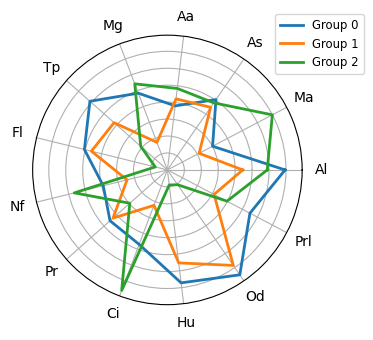

In [3]:
prototipos_wine = np.array([
    [0.69462451, 0.30102398, 0.50486323, 0.38088541, 0.48462558, 0.61117455, 
     0.50463021, 0.39018754, 0.45255102, 0.47012358, 0.67152140, 0.75235684,
     0.55011285],
    [0.44473684, 0.21146245, 0.44919786, 0.42268041, 0.17391304, 0.42068966,
     0.46202532, 0.24528302, 0.42902208, 0.22354949, 0.55284553, 0.68498168,
     0.31098431],
    [0.58947368, 0.69960474, 0.48128342, 0.48453608, 0.54347826, 0.21034483,
     0.07383966, 0.56603774, 0.29652997, 0.76109215, 0.08943089, 0.10622711,
     0.39728959]
])

labels = [
    'Al', 'Ma', 'As', 'Aa', 'Mg', 'Tp', 
    'Fl', 'Nf', 'Pr', 'Ci', 
    'Hu', 'Od', 'Prl'
]

#labels = [
 #   'Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols', 
 #   'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 
  #  'Hue', 'OD', 'Proline'
#]

num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(3.5, 3.5), subplot_kw=dict(polar=True))

for i, prototipo in enumerate(prototipos_wine):
    data = np.concatenate((prototipo, [prototipo[0]]))
    ax.plot(angles, data, label=f'Group {i}', linewidth=2)
    #ax.fill(angles, data, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_yticklabels([])
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1), fontsize='small')

plt.show()